In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import shap

In [3]:
df = pd.read_csv("../data/raw/bank-additional/bank-additional-full.csv",sep=";")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [4]:
print('JOB:',df['job'].unique())
print('MARITAL:',df['marital'].unique())
print('education:',df['education'].unique())
print('default:',df['default'].unique())
print('housing:',df['housing'].unique())
print('loan:',df['loan'].unique())
print('contact:',df['contact'].unique())
print('month:',df['month'].unique())
print('day_of_week:',df['day_of_week'].unique())
print('poutcome:',df['poutcome'].unique())
print('y:',df['y'].unique())

JOB: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
MARITAL: ['married' 'single' 'divorced' 'unknown']
education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default: ['no' 'unknown' 'yes']
housing: ['no' 'yes' 'unknown']
loan: ['no' 'yes' 'unknown']
contact: ['telephone' 'cellular']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome: ['nonexistent' 'failure' 'success']
y: ['no' 'yes']


In [5]:
coded_df = df

# Make sure all categorical variables are of string type
categorical_cols = ["job", "marital", "education", "default", "housing", "loan",
                    "contact", "month", "day_of_week", "poutcome"]
coded_df[categorical_cols] = coded_df[categorical_cols].astype(str)

# 1. Handling binary variables (default, housing, loan)
binary_cols = ["default", "housing", "loan", "contact", "poutcome"]
for col in binary_cols:
    if col == "contact":
        coded_df[col] = coded_df[col].map({"telephone": 1, "cellular": 0})
    elif col == "poutcome":
        coded_df[col] = coded_df[col].map({"nonexistent": 0, "failure": -1, "success": 1})
    else:
        coded_df[col] = coded_df[col].map({"no": -1, "yes": 1, "unknown": 0})  # Handling unknown values

# 2. deal with time variable(month, day_of_week)
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_mapping = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}

# Mapping Values
coded_df["month"] = coded_df["month"].map(month_mapping)
coded_df["day_of_week"] = coded_df["day_of_week"].map(day_mapping)

# 3. One-Hot Encoding of the remaining categorical variables
onehot_cols = ["job", "marital", "education"]
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")
encoded_features = encoder.fit_transform(coded_df[onehot_cols])

# Creating One-Hot DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(onehot_cols))

# 4. Merge One-Hot Encoded Data
coded_df = coded_df.drop(columns=onehot_cols).reset_index(drop=True)
coded_df = pd.concat([coded_df, encoded_df], axis=1)

# 5. Target variable encoding
coded_df["y"] = coded_df["y"].map({"no": 0, "yes": 1})

coded_df.to_csv("bank_processed.csv", index=False)

# 6. View the encoded data
coded_df.head()

,age,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,...,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown
0,56,-1,-1,-1,1,5,1,261,1,999,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57,0,-1,-1,1,5,1,149,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37,-1,1,-1,1,5,1,226,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,40,-1,-1,-1,1,5,1,151,1,999,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56,-1,-1,1,1,5,1,307,1,999,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


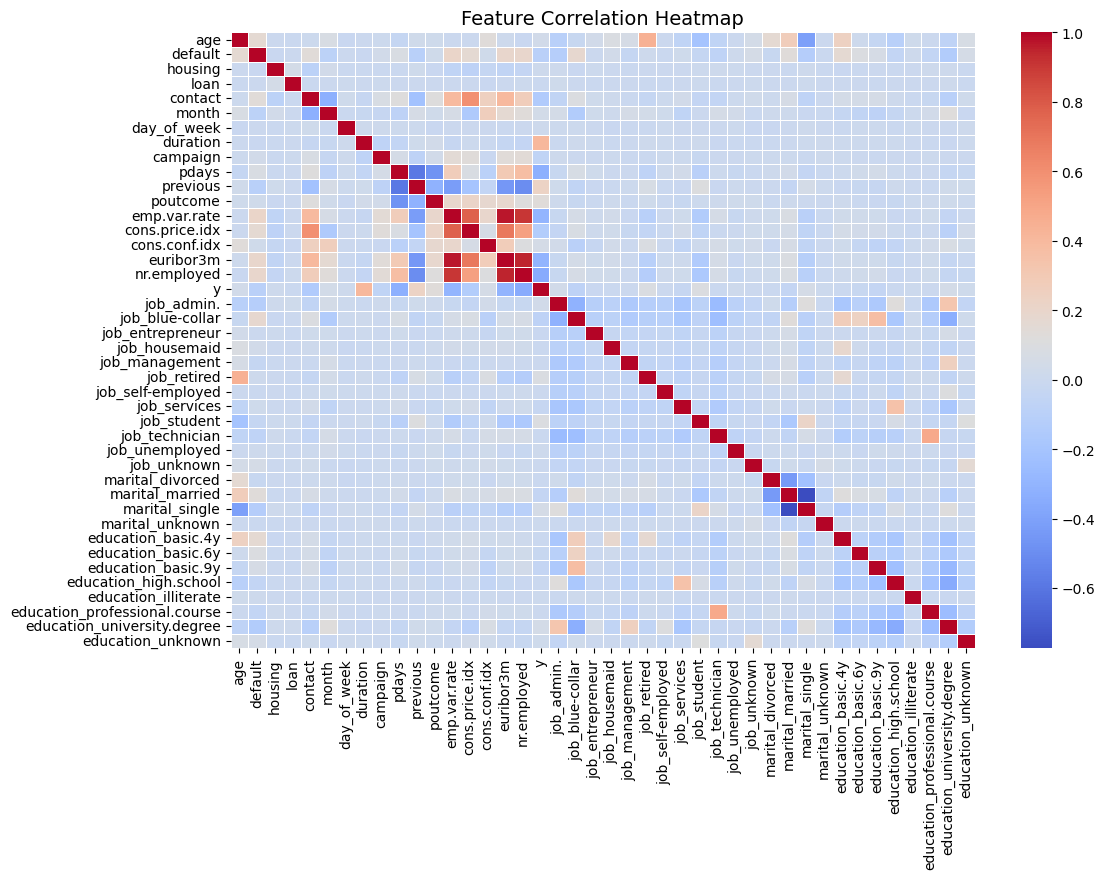

In [6]:
# 计算相关系数矩阵
corr_matrix = coded_df.corr()

# 设置图形大小
plt.figure(figsize=(12, 8))

# 绘制热力图
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)

# 设置标题
plt.title("Feature Correlation Heatmap", fontsize=14)

# 显示图像
plt.show()

In [8]:
# Split features (X) and target variable (y)
# X = coded_df.drop(columns=["y"])
X = coded_df.drop(columns=["y","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed","duration"])
y = coded_df["y"]

# 80% training set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Defining the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",  # Suitable for binary classification tasks
    eval_metric="logloss",  # Evaluation indicators
)

# model training
xgb_clf.fit(X_train, y_train)

# predict
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuary: {acc:.4f}")

XGBoost Accuary: 0.8933


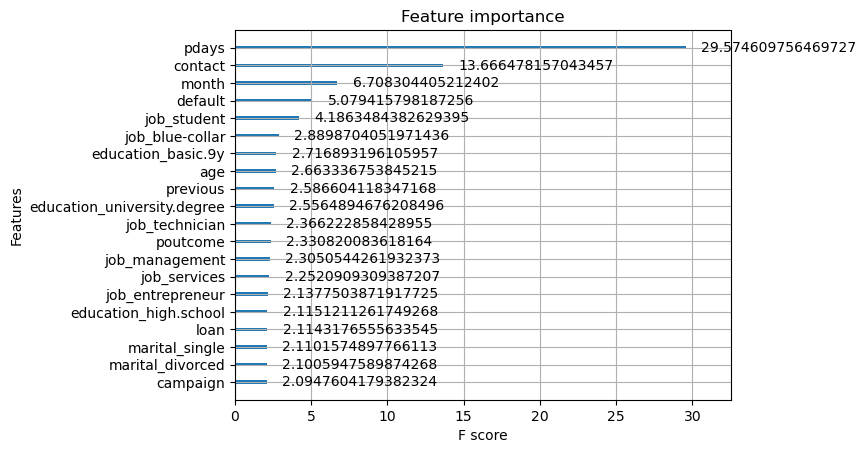

In [10]:
xgb.plot_importance(xgb_clf, importance_type="gain", max_num_features=20)  # top 20 features
plt.show()

X-axis: SHAP values, representing the impact of a feature on the prediction (positive means increasing the probability of subscription, negative means decreasing).

Y-axis: Feature names, sorted by importance from top to bottom.

**Color**:

    -Red (high values): The feature has a high numerical value.
    
    -Blue (low values): The feature has a low numerical value.
    
**Scatter distribution**:

    -If high values (red) are on the right, increasing this feature increases subscription likelihood.
    
    -If high values (red) are on the left, increasing this feature decreases subscription likelihood.
    
    -If there’s no clear trend, the feature's influence is more complex.

 95%|=================== | 7856/8238 [00:14<00:00]       

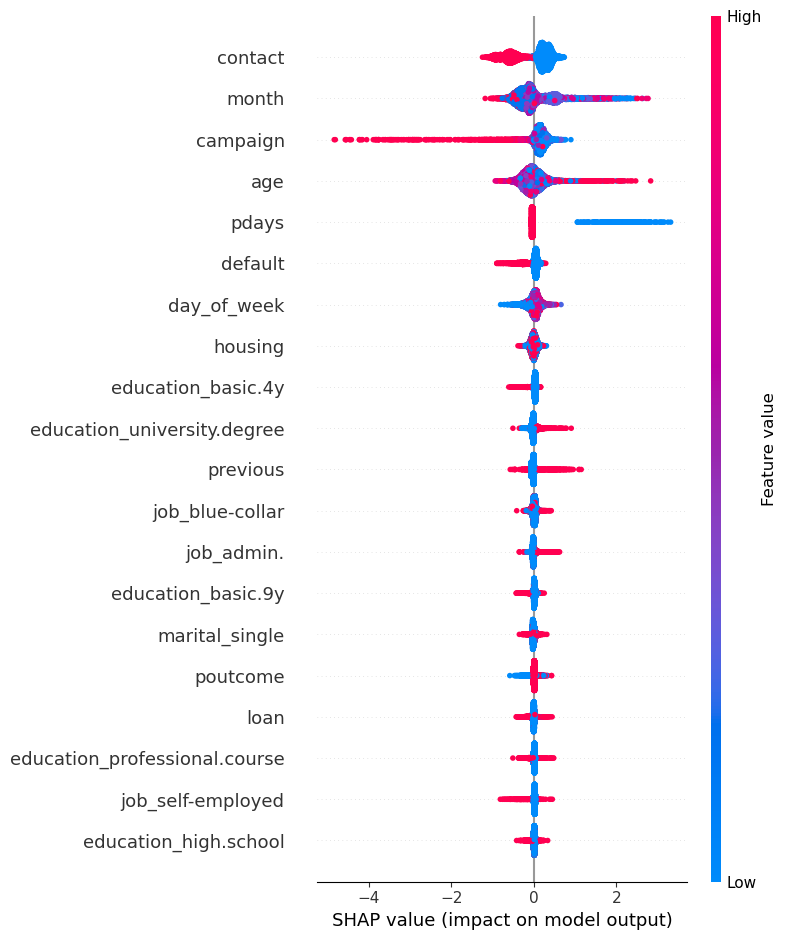

In [11]:
# Calculating SHAP Values
explainer = shap.Explainer(xgb_clf, X_train)
shap_values = explainer(X_test)

# Draw the overall impact
shap.summary_plot(shap_values, X_test)

**Vertical axis**: variable name (sorted by interaction SHAP importance).

**Horizontal axis**: interaction SHAP value (positive value indicates positive contribution to y=1, negative value indicates greater contribution to y=0).

**Color**: feature value size (red = larger value, blue = smaller value).

**Distribution of points**: The denser the points, the more stable the interaction effect of the feature.

d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:600: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))
d:\software\Anaconda3\lib\site-packages\shap\plots\_beeswarm.py:619: UserWarning: Attempting to set identical low and high xlims makes transformation singular; 

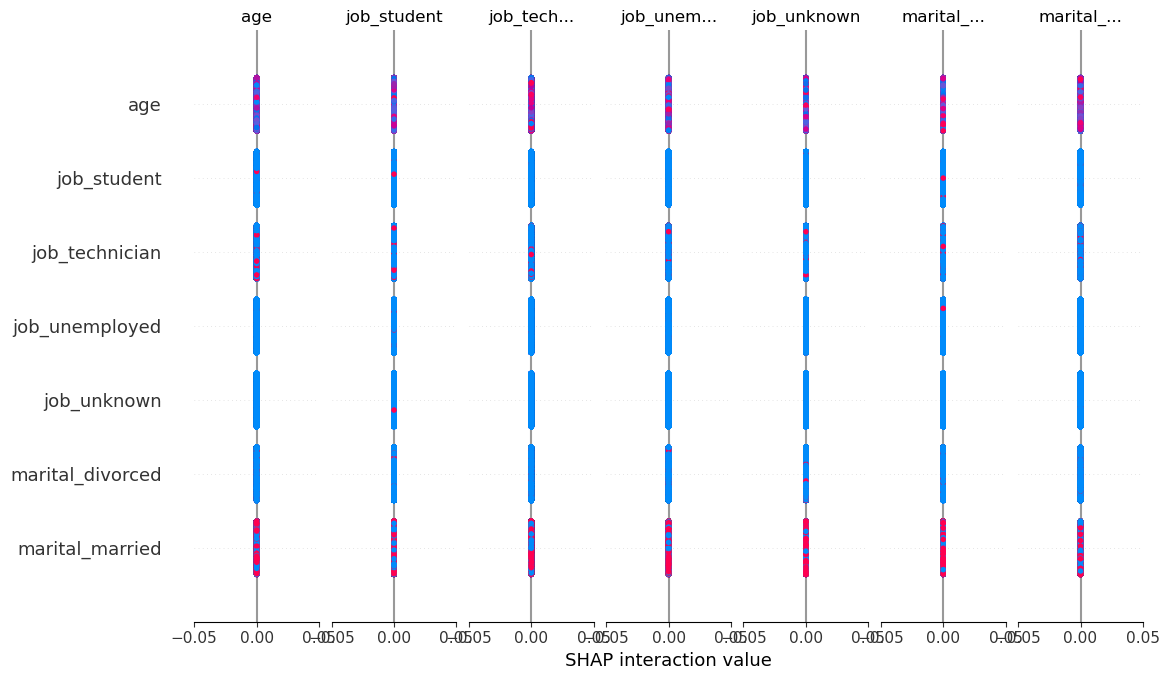

In [12]:
# Calculating SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X)

# Visualizing Cross-Factor SHAP Values
shap.summary_plot(shap_interaction_values, X)

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# 2. Build a logistic regression pipeline
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# 3. Training the Model
model.fit(X_train, y_train)

# 4. Prediction
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 5. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Accuracy: 0.8956057295460063
ROC AUC: 0.7296750071943183
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7303
           1       0.63      0.19      0.29       935

    accuracy                           0.90      8238
   macro avg       0.77      0.59      0.62      8238
weighted avg       0.87      0.90      0.87      8238



In [14]:
# View features that influence ranking
feature_importance = model.named_steps["logreg"].coef_[0]
importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance})
importance_df.sort_values(by="Importance", ascending=False, inplace=True)
print(importance_df)

                          Feature  Importance
9                        previous    0.146563
16                    job_retired    0.136432
19                    job_student    0.124381
10                       poutcome    0.122940
0                             age    0.093037
33    education_university.degree    0.060663
25                 marital_single    0.056398
6                     day_of_week    0.045304
21                 job_unemployed    0.042908
11                     job_admin.    0.027933
34              education_unknown    0.021994
31           education_illiterate    0.016026
26                marital_unknown    0.003695
28             education_basic.6y   -0.003003
27             education_basic.4y   -0.004883
2                         housing   -0.005538
20                 job_technician   -0.006098
32  education_professional.course   -0.006995
22                    job_unknown   -0.011203
3                            loan   -0.011279
17              job_self-employed 

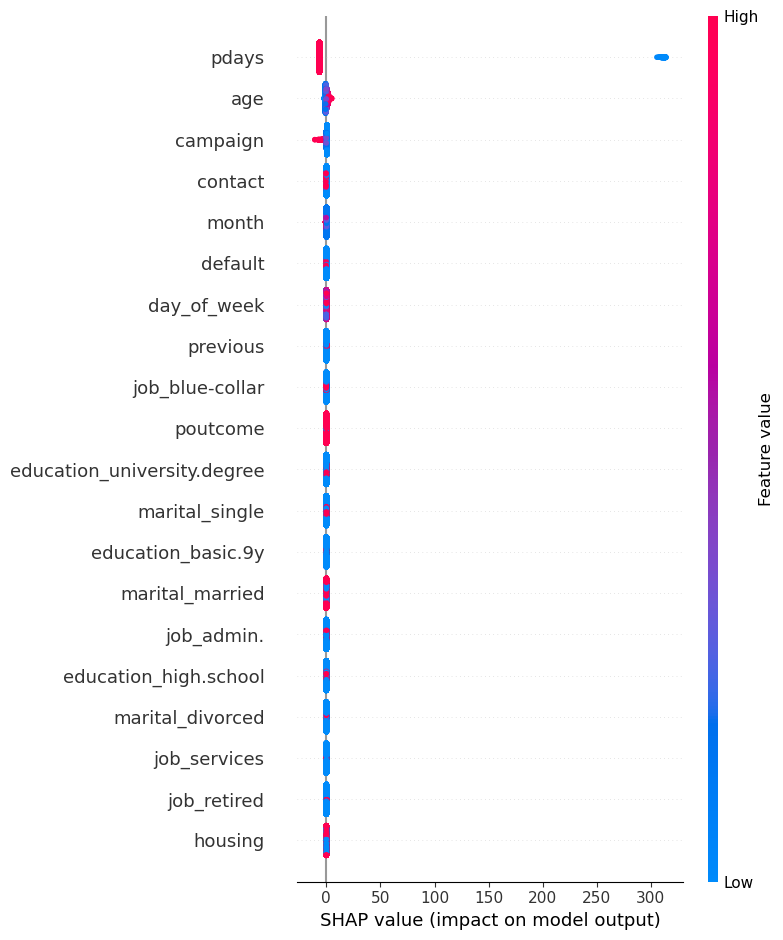

In [15]:
explainer = shap.LinearExplainer(model.named_steps["logreg"], X_train)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
plt.show()

1️⃣ pdays has the greatest impact on prediction:

The SHAP value distribution range of pdays is the largest, indicating that it is the most important influencing factor.
There is an extreme point on the right, which means that some pdays values ​​may have a great impact on y=0 (no subscription).

2️⃣ age is also an important feature:

age has the second largest impact on the prediction results.
The SHAP value of age is relatively symmetrical, indicating that different age groups may have different impacts on y.

3️⃣ campaign and contact have a greater impact:

campaign: indicates the number of times the bank markets to customers, and its SHAP value distribution indicates that the number of marketing may affect the customer's decision.
contact: the customer's contact information (telephone or mobile phone), and its SHAP value indicates that the contact information may be related to the subscription decision.

4️⃣ Some features have SHAP values ​​close to 0 and have less impact:

For example, marital_divorced, job_services, and housing, indicating that these features have a weak impact on the final prediction.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1️⃣ Define Treatment variables (e.g. whether a contact is cellular)
coded_df["treatment"] = (coded_df["contact"] == "cellular").astype(int)

# 2️⃣ Choosing Confounders
confounders = ["age", "default", "previous", "poutcome", "job_retired", "job_student", 
               "marital_single", "education_university.degree", "day_of_week"]

# 3️⃣ Standardizing Numeric Variables
scaler = StandardScaler()
coded_df[confounders] = scaler.fit_transform(coded_df[confounders])

# 4️⃣ Calculating Propensity Score
ps_model = LogisticRegression()
ps_model.fit(coded_df[confounders], coded_df["treatment"])
coded_df["propensity_score"] = ps_model.predict_proba(coded_df[confounders])[:, 1]

# View the propensity score distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(coded_df["propensity_score"], kde=True, hue=coded_df["treatment"])
plt.title("Propensity Score Distribution")
plt.show()
